In [ ]:
# 라이브러리 설치
!pip install -q --upgrade google-cloud-speech openai-whisper jiwer koreanize_matplotlib
!apt install -y -qq ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 41.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.1/334.1 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s 

In [ ]:
# 인증키 업로드 및 환경변수 설정
from google.colab import files
import os

uploaded = files.upload()  # 서비스 계정 키 JSON 업로드
json_key_file = list(uploaded.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_key_file

Saving google-cloud-addinedu-dl-proj.json to google-cloud-addinedu-dl-proj.json


In [ ]:
# 테스트용 음성 파일 업로드 (WAV 형식, 16000Hz 권장)
print("🎤 테스트할 WAV 파일을 업로드하세요")
uploaded_audio = files.upload()
audio_file_path = list(uploaded_audio.keys())[0]

🎤 테스트할 WAV 파일을 업로드하세요


Saving sample_01_mono.wav to sample_01_mono.wav


In [ ]:
from google.colab import files

# 실제 정답 문장이 담긴 txt 파일 업로드
uploaded_txt = files.upload()
txt_filename = list(uploaded_txt.keys())[0]

Saving sample_01_text.txt to sample_01_text.txt


In [ ]:
# MONO WAV (LINEAR16)로 변환
# !ffmpeg -y -i "{audio_file_path}" -ac 1 "mono.wav"
# audio_file_path = "mono.wav"

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
from jiwer import wer
import whisper
import time
from google.cloud import speech_v1p1beta1 as speech
import io
import pandas as pd

# 파일에서 텍스트 불러오기
with open(txt_filename, 'r', encoding='utf-8') as f:
    real_txt = f.read().strip().lower()

# 결과 저장용 딕셔너리
wer_results = {}
time_results = {}
transcript_results = {}

# Google STT 함수 (시간 측정 제거)
def transcribe_google(audio_path):
    client = speech.SpeechClient()

    with io.open(audio_path, "rb") as audio_file:
        content = audio_file.read()

    audio = speech.RecognitionAudio(content=content)
    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=44100,
        language_code="en-US",  # 실제 언어에 맞게 수정
    )

    response = client.recognize(config=config, audio=audio)

    transcript = ""
    for result in response.results:
        transcript += result.alternatives[0].transcript
    return transcript

# Google STT 테스트
google_start = time.time()
google_result = transcribe_google(audio_file_path)
google_duration = time.time() - google_start
google_wer = wer(real_txt, google_result.strip().lower())

wer_results["google"] = google_wer
time_results["google"] = google_duration
transcript_results["google"] = google_result
print("Google STT 처리 완료")

# Whisper 모델별 테스트
for model_name in ['small', 'medium', 'large-v2']:
    model = whisper.load_model(model_name)

    start = time.time()
    result = model.transcribe(audio_file_path, language='en')
    duration = time.time() - start
    transcript = result['text'].strip().lower()

    wer_score = wer(real_txt, transcript)

    wer_results[model_name] = wer_score
    time_results[model_name] = duration
    transcript_results[model_name] = result['text']
    print(f"Whisper {model_name} STT 처리 완료")

df = pd.DataFrame({
    "WER": wer_results,
    "Time (sec)": time_results,
    "Transcript": transcript_results
})

# 결과 출력
display(df)

Google STT 처리 완료


100%|████████████████████████████████████████| 461M/461M [00:04<00:00, 103MiB/s]


Whisper small STT 처리 완료


100%|██████████████████████████████████████| 1.42G/1.42G [00:11<00:00, 138MiB/s]


Whisper medium STT 처리 완료


100%|█████████████████████████████████████| 2.87G/2.87G [00:49<00:00, 62.6MiB/s]


Whisper large-v2 STT 처리 완료


,WER,Time (sec),Transcript
google,0.960784,8.594692,81171825333117 land on 825 Ms on 817 1153 on 8...
small,0.862745,3.942031,"C9217, runway 825, wind 330, red 101, set lan..."
medium,0.901961,5.209418,"GDM 8117, Run 825, wind 330 at 117, land GDM ..."
large-v2,0.745098,7.197048,"Air Busan 8117, Runway 25, wind 330 at 100, c..."


In [ ]:
df.to_csv('stt_results.csv', index=False, encoding='utf-8-sig')

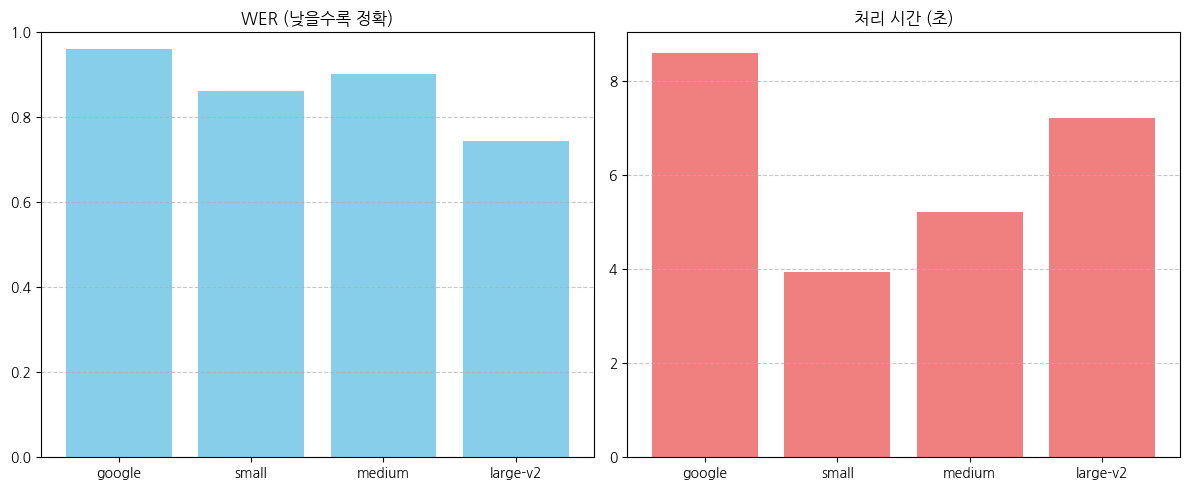

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# WER 그래프
ax1.bar(df.index, df['WER'], color='skyblue')
ax1.set_title("WER (낮을수록 정확)")
ax1.set_ylim(0, 1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 처리 시간 그래프
ax2.bar(df.index, df['Time (sec)'], color='lightcoral')
ax2.set_title("처리 시간 (초)")
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()